In [3]:
import re
import csv
import time
import tweepy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Preparing for Sentiment Analysis

## MySQL Authorization


In [2]:
import mysql.connector
from mysql.connector import Error

from mysql_credentials import *

host = HOST
user = USER
password = PASSWORD
database = 'twitter'

### Connecting to MySQL Server

In [3]:
def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host = host_name,
            user = user_name,
            passwd = user_password
        )
        print("MySQL Database connection successful!")
    except Error as err:
        print(f"Error: '{err}'")
    return connection

### Connecting to the Database


In [4]:
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host = host_name,
            user = user_name,
            passwd = user_password,
            database = db_name
        )
        print("MySQL Database connection successful!")
    except Error as err:
        print(f"Error: '{err}'")
        
    return connection

### Select Function

In [5]:
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

### Read Data from MySQL Server into a Pandas DataFrame


In [6]:
sql_query = """
SELECT id_str, username, tweets, clean_tweets,created_at, location, source, likes, retweet_count
FROM tweets;
"""
connection = create_db_connection(host, user, password, database)
results = read_query(connection, sql_query)
connection.close()

# Returns a list of lists and then creates a pandas DataFrame
from_db = []

if results is not None:
    for result in results:
        result = list(result)
        from_db.append(result)
    columns = ["id_str", "username", "tweets", "clean_tweets","created_at", "location", "source", "likes", "retweet_count"]
    df = pd.DataFrame(from_db, columns = columns)
df.tail(3)

MySQL Database connection successful!


,id_str,username,tweets,clean_tweets,created_at,location,source,likes,retweet_count
133742,1468962794913419278,PalvishaNaveed,"As they step into Christmas, it's a pleasure ...","As they step into Christmas, it's a pleasure ...",2021-12-09 15:16:36,,Twitter Web App,0,0
133743,1468962778933125132,romicrypto354,@NukeGold @capital_counsel @CelsiusNetwork Dec...,December gem will be Mini Shiba Floki ($MSF...,2021-12-09 15:16:33,,Twitter for Android,0,0
133744,1468962776886308869,cmva1075fm,Now playing @CalebtheWolfe - SMALL TOWN COUNTR...,Now playing - SMALL TOWN COUNTRY LOVE on CMVA...,2021-12-09 15:16:32,"Charlotte, North Carolina",Radio.co now playing,0,0


In [7]:
print(f"Dataframe size before removing duplicate tweets {df.shape[0]}")
df.drop_duplicates(inplace = True)
print(f"Dataframe size after removing duplicate tweets {df.shape[0]}")

Dataframe size before removing duplicate tweets 133745
Dataframe size after removing duplicate tweets 56005


In [8]:
df.loc[0:5 ,["tweets", "clean_tweets"]]

,tweets,clean_tweets
0,@binance_verse BinanceVerse is great and this ...,BinanceVerse is great and this projector has ...
1,"@astroversespace Wonderful project, this proje...","Wonderful project, this project is very good ..."
2,@WatcherGuru NEW LOW MCAP P2E GAME TOKEN 💎\n @...,NEW LOW MCAP P2E GAME TOKEN 💎 🪙 🧨ONLY 150K ...
3,@metagalaxyland Good project \n@shakira @Being...,Good project metagalaxyland metaverse aird...
4,Little sneak peak of tomorrow drop\nAny idea w...,Little sneak peak of tomorrow dropAny idea wha...
5,@KeepC0unting Why did the hermit crab cross th...,Why did the hermit crab cross the road?To get...


In [9]:
print(df["tweets"][9])
print()
print(df["clean_tweets"][9])

@finn_exchange Don't waste this golden opportunity, let's join the community and build this community
@icl_ical 
@ican 
@HakimAlfani 
#Fantom #ftm #finnexchange #Giveaways #airdropalert #Airdropinspector #AirdropDet #airdroptoken #FreeCrypto 
#Crypto #AirdropSolana

 Don't waste this golden opportunity, let's join the community and build this community   Fantom ftm finnexchange Giveaways airdropalert Airdropinspector AirdropDet airdroptoken FreeCrypto Crypto AirdropSolana


# Sentiment Analysis

### Creating a Function to Get the Subjectivity, Polarity and Sentiment

In [10]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Assign tweet sentiment analysis (positive, negative or neutrals)
def getSentiment(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
#  Create ‘subjectivity’, ‘polarity’ and 'sentiment' columns
df['subjectivity'] = df['clean_tweets'].apply(getSubjectivity)
df['polarity'] = df['clean_tweets'].apply(getPolarity)
df['sentiment'] = df['polarity'].apply(getSentiment)

print(df.shape)
df.head()

(56005, 12)


,id_str,username,tweets,clean_tweets,created_at,location,source,likes,retweet_count,subjectivity,polarity,sentiment
0,1468268252791025675,yubee131,@binance_verse BinanceVerse is great and this ...,BinanceVerse is great and this projector has ...,2021-12-07 19:16:45,Uyo,Twitter for Android,0,0,0.527083,0.433333,Positive
1,1468268252530757632,AhmadIsroulMub1,"@astroversespace Wonderful project, this proje...","Wonderful project, this project is very good ...",2021-12-07 19:16:45,None,Twitter for Android,0,0,0.541000,0.682000,Positive
2,1468268251373350921,CryptoBilioners,@WatcherGuru NEW LOW MCAP P2E GAME TOKEN 💎\n @...,NEW LOW MCAP P2E GAME TOKEN 💎 🪙 🧨ONLY 150K ...,2021-12-07 19:16:44,None,Twitter for iPhone,0,0,0.384848,-0.087879,Negative
3,1468268250995720195,keceng000,@metagalaxyland Good project \n@shakira @Being...,Good project metagalaxyland metaverse aird...,2021-12-07 19:16:44,None,Twitter for Android,0,0,0.600000,0.700000,Positive
4,1468268250551177216,KoniCats,Little sneak peak of tomorrow drop\nAny idea w...,Little sneak peak of tomorrow dropAny idea wha...,2021-12-07 19:16:44,None,Twitter for iPhone,0,0,0.500000,-0.187500,Negative


# Visualizing Sentiment Analysis

### Total Positive, Negative and Neutral Tweets

In [11]:
df["sentiment"].value_counts()

Positive    29374
Neutral     21299
Negative     5332
Name: sentiment, dtype: int64

### Bar Plot

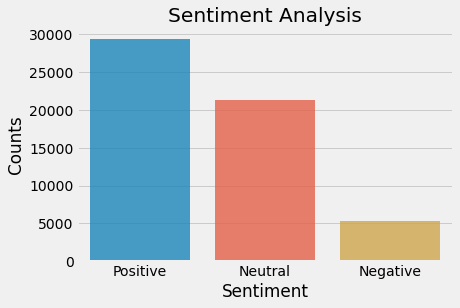

In [12]:
plt.style.use('fivethirtyeight')

chart = df["sentiment"].value_counts()
sns.barplot(x=chart.index, y=chart.values, alpha=0.8)
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
plt.show()

### Scatter plot

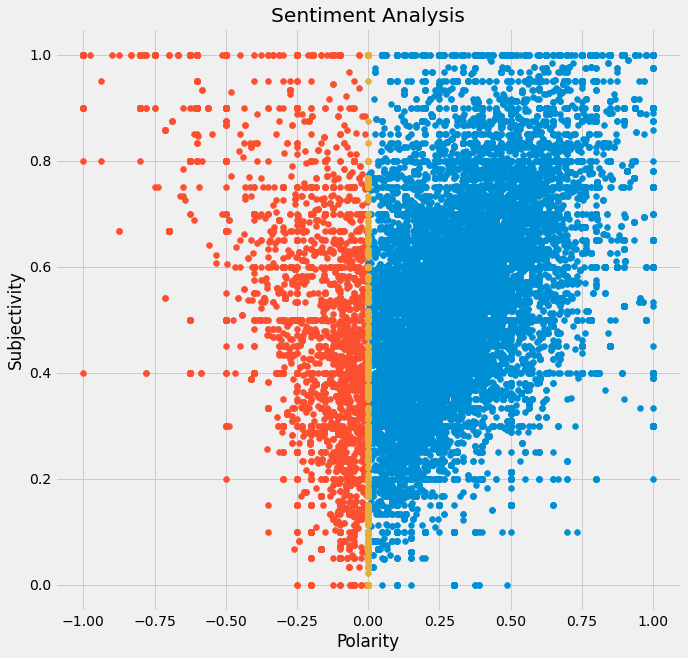

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))

df_temp = df[df['sentiment'] == 'Positive']
plt.scatter(df_temp['polarity'], df_temp['subjectivity'])

df_temp = df[df['sentiment'] == 'Negative']
plt.scatter(df_temp['polarity'], df_temp['subjectivity'])

df_temp = df[df['sentiment'] == 'Neutral']
plt.scatter(df_temp['polarity'], df_temp['subjectivity'])
df_temp = None

plt.title("Sentiment Analysis")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()

# WordCloud

## WordCloud for all of the Tweets
### Combining All Clean Tweets Into One Big Text

In [14]:
text = " ".join(tweet for tweet in df.clean_tweets)
print ("There are {} words in the combination of all selected clean tweets.".format(len(text)))

There are 8816156 words in the combination of all selected clean tweets.


## WordCloud- Version 1

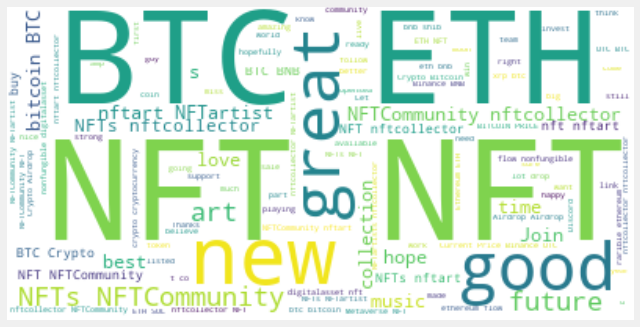

In [15]:
plt.figure(figsize=(10,10))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["one", "Check", "will", "project", "today", "make", "look", "day", "thank", "go", "see", "now", 
                  "via"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## WordCloud- Only Positive Tweets

In [16]:
# Sub-setting the tweets to only get the positive tweets
df_temp = df[df['sentiment'] == 'Positive']

positive_text = " ".join(tweet for tweet in df_temp.clean_tweets)
print ("There are {} words in the combination of all selected POSITIVE clean tweets.".format(len(positive_text)))

There are 5073662 words in the combination of all selected POSITIVE clean tweets.


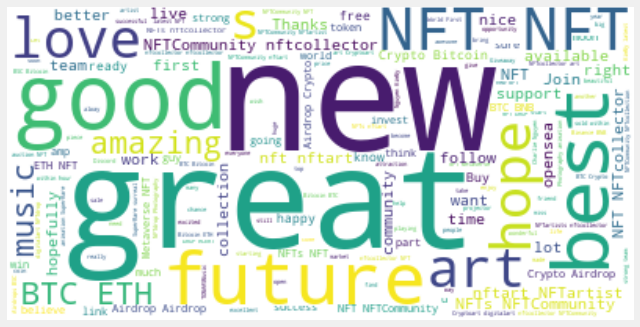

In [17]:
plt.figure(figsize=(10,10))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_text)

# Display the generated image the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Horizontal Bar Chart

## Horizontal Bar Chart- With All Words

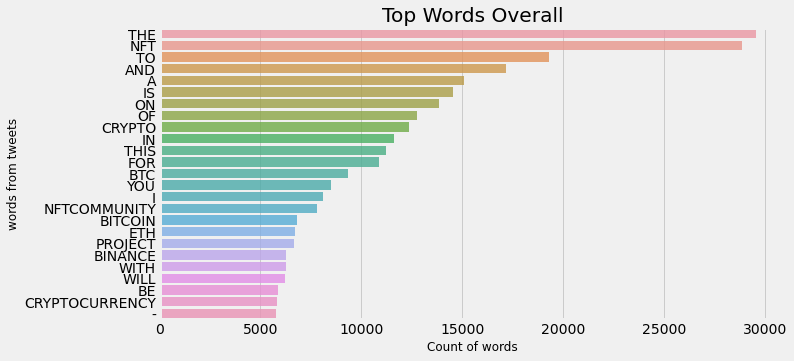

In [18]:
allwords = ' '.join([tweets for tweets in df['clean_tweets']])

df2 = pd.DataFrame(allwords.split(), columns=['word'])
df2_1 = df2['word'].str.strip().str.upper().replace({'NFTS':'NFT'}).value_counts()
df2_1 = df2_1[:25,]

plt.figure(figsize=(10,5))
sns.barplot(df2_1.values, df2_1.index, alpha=0.8)

plt.title('Top Words Overall')
plt.ylabel("words from tweets", fontsize = 12)
plt.xlabel("Count of words", fontsize = 12)
plt.show()

## Horizontal Bar Chart- Cleaned

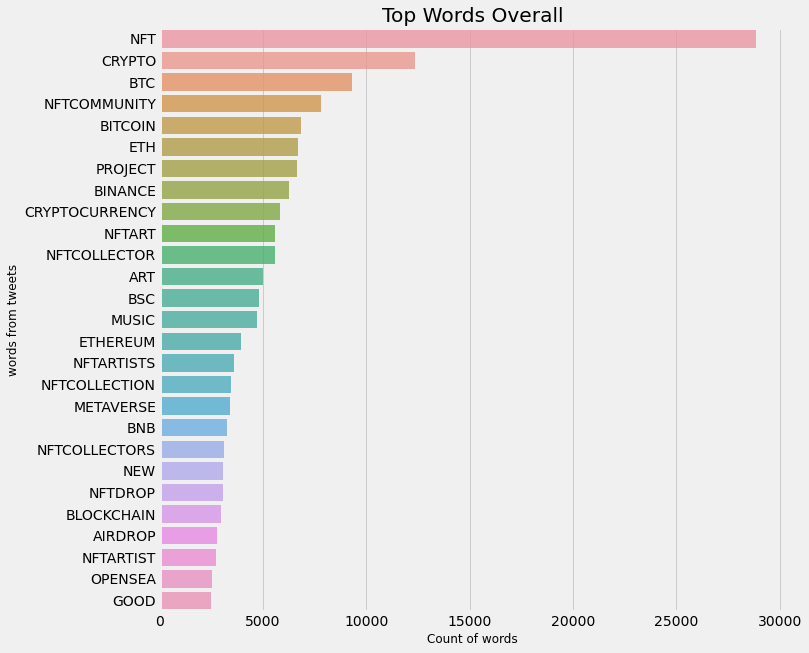

In [19]:
allwords = ' '.join([tweets for tweets in df['clean_tweets']])

df2 = pd.DataFrame(allwords.split(), columns=['word'])
df2_1 = df2['word'].str.strip().str.upper().replace({'NFTS':'NFT'}).value_counts()
df2_1 = df2_1[:60,]
df2_1.drop(labels=["THE", "TO", "AND", "A", "IS", "ON", "OF", "IN", "THIS", "FOR", "YOU", "I", "WITH", "WILL", "BE", 
                   "-", "MY", "YOUR", "IT", "BY", "ARE", "AT", "OUT", "&AMP;", "NOW", "FROM", "OUR", "THAT", "CAN",
                   "HAVE", "HAS", "VERY", "WE"], axis = 0, columns = None, level = None, inplace = True)

plt.figure(figsize=(10,10))
sns.barplot(df2_1.values, df2_1.index, alpha=0.8)

plt.title('Top Words Overall')
plt.ylabel("words from tweets", fontsize = 12)
plt.xlabel("Count of words", fontsize = 12)
plt.show()